In [98]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import pycountry_convert as pc
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from collections import Counter, defaultdict

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, LancasterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer

In [99]:
df = pd.read_csv('transaction_data.csv')
df.head()

,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country
0,278166,6355745,Sat Feb 02 12:50:00 IST 2019,465549,FAMILY ALBUM WHITE PICTURE FRAME,6,11.73,United Kingdom
1,337701,6283376,Wed Dec 26 09:06:00 IST 2018,482370,LONDON BUS COFFEE MUG,3,3.52,United Kingdom
2,267099,6385599,Fri Feb 15 09:45:00 IST 2019,490728,SET 12 COLOUR PENCILS DOLLY GIRL,72,0.90,France
3,380478,6044973,Fri Jun 22 07:14:00 IST 2018,459186,UNION JACK FLAG LUGGAGE TAG,3,1.73,United Kingdom
4,-1,6143225,Mon Sep 10 11:58:00 IST 2018,1733592,WASHROOM METAL SIGN,3,3.40,United Kingdom


### Cleaning

In [100]:
df.info() 
# item description has nans

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1083818 entries, 0 to 1083817
Data columns (total 8 columns):
UserId                    1083818 non-null int64
TransactionId             1083818 non-null int64
TransactionTime           1083818 non-null object
ItemCode                  1083818 non-null int64
ItemDescription           1080910 non-null object
NumberOfItemsPurchased    1083818 non-null int64
CostPerItem               1083818 non-null float64
Country                   1083818 non-null object
dtypes: float64(1), int64(4), object(3)
memory usage: 66.2+ MB


In [101]:
df[['UserId', 'TransactionId', 'ItemCode', 'NumberOfItemsPurchased', 'CostPerItem']].describe().T

# UserId and ItemCode columns have min -1 (probably missing/mislabelled)
# NumberOfItemsPurchased and CostPerItem have -ve values (maybe corresponding to above cases)

,count,mean,std,min,25%,50%,75%,max
UserId,1083818.0,2.410162e+05,142336.431264,-1.00,259392.00,302022.00,341355.0,384027.00
TransactionId,1083818.0,6.159417e+06,147634.093880,5900015.00,6026856.00,6166611.00,6289569.0,6397457.00
ItemCode,1083818.0,6.582687e+05,452631.426503,-1.00,460908.00,475293.00,488943.0,1894494.00
NumberOfItemsPurchased,1083818.0,2.865675e+01,654.243172,-242985.00,3.00,9.00,30.0,242985.00
CostPerItem,1083818.0,9.498798e+00,2308.138578,-15265.64,1.73,2.88,5.7,1696285.44


In [102]:
df.loc[df['UserId'] == -1].head() # entries with userid -1

,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country
4,-1,6143225,Mon Sep 10 11:58:00 IST 2018,1733592,WASHROOM METAL SIGN,3,3.40,United Kingdom
7,-1,6143225,Mon Sep 10 11:58:00 IST 2018,447867,SKULLS WRITING SET,120,1.15,United Kingdom
13,-1,6058140,Mon Jul 02 07:33:00 IST 2018,435225,LUNCH BAG RED RETROSPOT,60,6.85,United Kingdom
17,-1,6288843,Sun Dec 30 12:58:00 IST 2018,489594,VINTAGE CHRISTMAS TABLECLOTH,3,34.45,United Kingdom
23,-1,6388019,Sat Feb 16 13:24:00 IST 2019,490329,ROLL WRAP VINTAGE CHRISTMAS,30,3.40,United Kingdom


In [103]:
df.loc[df['ItemCode'] == -1].head() # entries with itemcode -1

,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country
154,266301,5970085,Sat Apr 14 11:36:00 IST 2018,-1,POSTAGE,9,24.84,France
251,266028,5969843,Sat Apr 14 09:27:00 IST 2018,-1,POSTAGE,21,24.84,Germany
993,287574,6190756,Sun Oct 21 10:27:00 IST 2018,-1,Discount,-3,88.32,United Kingdom
1261,264243,6153851,Wed Sep 19 08:22:00 IST 2018,-1,POSTAGE,6,24.84,France
1293,-1,6026130,Wed Jun 06 11:50:00 IST 2018,-1,DOTCOM POSTAGE,3,304.58,United Kingdom


In [104]:
df.loc[df['ItemCode'] == -1]['ItemDescription'].unique() # descriptions of itemcode -1

# Observation: Some are not products - Discount, Postage, Bank charges, Adjust bad debt, Amazon fee, etc

array(['POSTAGE', 'Discount', 'DOTCOM POSTAGE', 'AMAZON FEE', 'Manual',
       'SAMPLES', 'GIRLS PARTY BAG', 'Bank Charges', 'BOYS PARTY BAG',
       'Adjust bad debt', 'CRUK Commission', 'PADS TO MATCH ALL CUSHIONS',
       nan], dtype=object)

In [105]:
# Assumption: If user id -1 was marked by mistake, we might find the same transaction ids of 
# userid -1 made by some valid user. If so, we can replace -1 with that userid. 

user_minus1_trasactions = df.loc[df['UserId'] == -1]['TransactionId']
df.loc[(df['TransactionId'].isin(user_minus1_trasactions)) & (df['UserId'] != -1)] # empty

# Conclusion: all transaction ids of userid -1 has been made only by userid -1 (cant replace)

,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country


In [106]:
# removing userid -1 and itemcode -1
df = df.loc[(df['UserId'] != -1) & (df['ItemCode'] != -1)]

In [107]:
df[['NumberOfItemsPurchased', 'CostPerItem']].describe()

# Observations: min NumberOfItemsPurchased is -ve and CostPerItem is 0
#               max of NumberOfItemsPurchased and CostPerItem are unnaturally large

,NumberOfItemsPurchased,CostPerItem
count,810086.000000,8.100860e+05
mean,36.306367,8.218450e+00
std,747.588721,2.665313e+03
min,-242985.000000,0.000000e+00
25%,6.000000,1.730000e+00
50%,15.000000,2.700000e+00
75%,36.000000,5.180000e+00
max,242985.000000,1.696285e+06


In [108]:
# Hypothesis: the -ve NumberOfItemsPurchased are cancelled orders

neg_no_items = df.loc[df['NumberOfItemsPurchased'] < 0]['NumberOfItemsPurchased'].to_numpy()
pos_no_items = df.loc[df['NumberOfItemsPurchased'] > 0]['NumberOfItemsPurchased'].to_numpy()

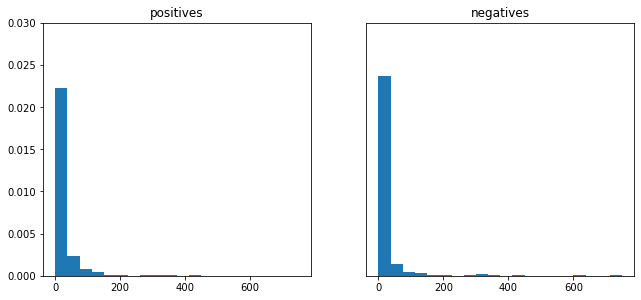

In [109]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(pos_no_items, bins = 20, density = True, range = (0, 750))
ax2.hist(-neg_no_items, bins = 20, density = True, range = (0, 750)) # make -ves -> +ve
ax1.set_title('positives')
ax2.set_title('negatives')
fig.tight_layout(pad = 0.1)
ax2.set_yticks([])
ax1.set_ylim([0, 0.03])
ax2.set_ylim([0, 0.03])
fig.set_figwidth(9)
plt.show()

# The distributions look similar (eg. the behaviour of most observations lying in the first
# bin holds for both histograms). This indicates a systematic nature for these -ve transactions. 
# These could have been mislabelled as -ves, or could indicate cancelled orders. 

In [110]:
df.loc[df['NumberOfItemsPurchased'] < 0].shape[0]

17080

In [111]:
itemcodes = df.loc[df['NumberOfItemsPurchased'] < 0]['ItemCode'].unique()
len(itemcodes)

1818

In [112]:
print(f"number of zero cost rows: {df.loc[df['CostPerItem'] == 0].shape[0]}")
print(f"number of unqiue itemcodes: {df.loc[df['CostPerItem'] == 0]['ItemCode'].nunique()}")
      
# Observation: there are exactly twice the number of transactions as there are itemcodes

number of zero cost rows: 66
number of unqiue itemcodes: 33


In [113]:
# Assumption: zero cost signifies orders that were returned (hence no overall transaction). Maybe, 
# instead of putting in a +ve cost for buying and -ve cost for a return, both costs were set to be zeros.
# So, there should be exactly 1 duplicate per zero CostPerItem row. 

itemcodes = itemcodes = df.loc[df['CostPerItem'] == 0]['ItemCode'].unique()

for code in itemcodes:
    filt = (df['CostPerItem'] < 0) & (df['ItemCode'] == code)
    temp = df.loc[filt]
    nrows = temp.shape[0]
    temp.drop_duplicates(inplace = True)
    if nrows != 2 * temp.shape[0]:
        display(HTML(df.loc[filt]['TransactionId'].value_counts().sort_values().to_frame().to_html()))
        ip = input('Input Enter to continue and q to break out :')
        if ip.lower() == 'q':
            break

# Observation: Code runs without any printing.
# Conclusion: Hence every zero CostPerItem row has exactly 1 duplicate.

In [114]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
UserId,810086.0,3.211936e+05,35914.936353,259266.0,293349.00,318339.0,352674.00,384027.00
TransactionId,810086.0,6.166424e+06,144170.889342,5900015.0,6040430.00,6180603.0,6292726.00,6397457.00
ItemCode,810086.0,6.459774e+05,432950.475946,42.0,462609.00,475986.0,488628.00,1894494.00
NumberOfItemsPurchased,810086.0,3.630637e+01,747.588721,-242985.0,6.00,15.0,36.00,242985.00
CostPerItem,810086.0,8.218450e+00,2665.313237,0.0,1.73,2.7,5.18,1696285.44


In [115]:
df.drop_duplicates(inplace = True) # duplicates of cancelled and returned orders
df.shape

(399788, 8)

In [116]:
df.loc[df['TransactionTime'].str.contains('2028')]

# Observation: Many transaction dates have recorded the year 2028. 
# Assumption: Its probably a logging error. We will replace 2028 with 2018

,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country
241,366870,5912049,Fri Feb 18 05:57:00 IST 2028,473613,PLASTERS IN TIN SKULLS,36,2.28,United Kingdom
602,369411,5914106,Fri Feb 18 11:39:00 IST 2028,481278,HERB MARKER PARSLEY,3,0.90,United Kingdom
1070,259287,5913886,Fri Feb 18 10:57:00 IST 2028,477246,ALARM CLOCK BAKELIKE GREEN,12,5.18,Iceland
1610,267708,5913864,Fri Feb 18 10:41:00 IST 2028,458346,EIGHT PIECE DINOSAUR SET,9,1.73,United Kingdom
1792,315504,5913688,Fri Feb 18 09:20:00 IST 2028,453432,RETROSPOT CIGAR BOX MATCHES,12,1.73,United Kingdom
...,...,...,...,...,...,...,...,...
1005863,333018,5913853,Fri Feb 18 10:31:00 IST 2028,481803,CHRISTMAS LIGHTS 10 VINTAGE BAUBLES,6,6.84,United Kingdom
1017804,352275,5913974,Fri Feb 18 11:15:00 IST 2028,464373,GREY HEART HOT WATER BOTTLE,9,5.18,United Kingdom
1039130,371175,5913699,Fri Feb 18 09:22:00 IST 2028,477246,ALARM CLOCK BAKELIKE GREEN,24,5.18,United Kingdom
1052713,297696,5912753,Fri Feb 18 07:45:00 IST 2028,448455,TOAST ITS - I LOVE YOU,36,1.73,United Kingdom


In [117]:
def get_date(transaction_time):
    
    month_num_dict = {
        'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04', 
        'May': '05', 'Jun': '06', 'Jul': '07', 'Aug': '08', 
        'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'
    }
    
    split = transaction_time.split(' ')
    month = month_num_dict[split[1]]
    date = [split[2], month, split[-1]]
    
    if date[-1] == '2028':
        date[-1] = '2018'
    
    return '/'.join(date)


In [118]:
df['TransactionDate'] = df['TransactionTime'].apply(get_date)
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

In [119]:
to_remove = df.loc[(df['NumberOfItemsPurchased'] <= 0) | (df['CostPerItem'] == 0)].index.to_list()
df.drop(to_remove, axis = 0, inplace = True)

In [120]:
df.head()

,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country,TransactionDate
0,278166,6355745,Sat Feb 02 12:50:00 IST 2019,465549,FAMILY ALBUM WHITE PICTURE FRAME,6,11.73,United Kingdom,2019-02-02
1,337701,6283376,Wed Dec 26 09:06:00 IST 2018,482370,LONDON BUS COFFEE MUG,3,3.52,United Kingdom,2018-12-26
2,267099,6385599,Fri Feb 15 09:45:00 IST 2019,490728,SET 12 COLOUR PENCILS DOLLY GIRL,72,0.90,France,2019-02-15
3,380478,6044973,Fri Jun 22 07:14:00 IST 2018,459186,UNION JACK FLAG LUGGAGE TAG,3,1.73,United Kingdom,2018-06-22
5,285957,6307136,Fri Jan 11 09:50:00 IST 2019,1787247,CUT GLASS T-LIGHT HOLDER OCTAGON,12,3.52,United Kingdom,2019-11-01


In [121]:
print(df['NumberOfItemsPurchased'].nlargest(10))
top_10 = df['NumberOfItemsPurchased'].nlargest(10).index

510647     242985
528376     222645
447048      14400
392207      12900
435734      11718
102131       9558
351064       9342
1050801      9342
511888       9000
190714       8640
Name: NumberOfItemsPurchased, dtype: int64


In [122]:
# Assumption: these items must have been bought on wholesale, so valid

df.loc[df.index.isin(top_10)].head()

,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country,TransactionDate
102131,306789,6166589,Sun Sep 30 13:04:00 IST 2018,378147,ESSENTIAL BALM 3.5g TIN IN ENVELOPE,9558,0.09,United Kingdom,2018-09-30
190714,271551,6186829,Tue Oct 16 14:06:00 IST 2018,1782459,ASSORTED COLOUR BIRD ORNAMENT,8640,2.01,United Kingdom,2018-10-16
351064,330729,6055071,Sat Jun 30 09:20:00 IST 2018,443268,FAIRY CAKE FLANNEL ASSORTED COLOUR,9342,2.90,United Kingdom,2018-06-30
392207,275835,6103548,Wed Aug 08 06:52:00 IST 2018,466137,SMALL POPCORN HOLDER,12900,1.00,United Kingdom,2018-08-08
435734,379827,5990732,Sun May 06 06:43:00 IST 2018,463113,EMPIRE DESIGN ROSETTE,11718,1.14,United Kingdom,2018-06-05


In [123]:
print(df['CostPerItem'].nlargest(10))

320282    1696285.44
124370        896.31
215267        896.31
275748        407.10
280931        407.10
385033        407.10
413843        407.10
581220        407.10
675780        407.10
816632        407.10
Name: CostPerItem, dtype: float64


In [124]:
# Observation: a cost of 1696285 for a lamp is unnatural, hence probably a logging error 

df.loc[df.index == 320282]

,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country,TransactionDate
320282,288687,5900323,Mon Feb 12 06:37:00 IST 2018,465780,RETROSPOT LAMP,24,1696285.44,United Kingdom,2018-12-02


In [125]:
df.drop(320282, axis = 0, inplace = True) # remove this invalid entry

In [126]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
UserId,391248.0,3.211932e+05,35912.973646,259266.00,293349.00,318297.0,352674.00,384027.00
TransactionId,391248.0,6.166532e+06,143955.885160,5900015.00,6041585.00,6180636.0,6292693.00,6397457.00
ItemCode,391248.0,6.459091e+05,432934.120479,42.00,462567.00,475986.0,488670.00,1894494.00
NumberOfItemsPurchased,391248.0,3.942495e+01,542.355868,3.00,6.00,18.0,36.00,242985.00
CostPerItem,391248.0,3.994441e+00,6.038447,0.06,1.73,2.7,5.18,896.31


### Feature Engineering

In [127]:
df.info() # no nans

<class 'pandas.core.frame.DataFrame'>
Int64Index: 391248 entries, 0 to 1081376
Data columns (total 9 columns):
UserId                    391248 non-null int64
TransactionId             391248 non-null int64
TransactionTime           391248 non-null object
ItemCode                  391248 non-null int64
ItemDescription           391248 non-null object
NumberOfItemsPurchased    391248 non-null int64
CostPerItem               391248 non-null float64
Country                   391248 non-null object
TransactionDate           391248 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 29.8+ MB


In [128]:
print(f"number of users = {df['UserId'].nunique()}")
print(f"number of items = {df['ItemCode'].nunique()}")
print(f"number of countries = {df['Country'].nunique()}")
print(f"number of transactions = {df['TransactionId'].nunique()}")

number of users = 4333
number of items = 3194
number of countries = 37
number of transactions = 18404


#### Number of purchases

In [129]:
df['UserId'].value_counts() # number of transactions per user

374661    7665
313131    5668
296016    5095
267708    4397
306726    2674
          ... 
380793       1
363951       1
372792       1
268611       1
295890       1
Name: UserId, Length: 4333, dtype: int64

In [130]:
users = df['UserId'].value_counts(sort = False).rename_axis('UserId').to_frame('n_transactions')
users.head()

,n_transactions
UserId,
272517,9
315546,60
329889,6
344232,43
358575,77


#### Avg transaction hour

In [131]:
def avg_transaction_hour(series):
    
    def get_hour(time_str):
        time = time_str.split(' ')[3]
        hour = float(time.split(':')[0])
        return hour
    
    hours = series.apply(get_hour)
    return np.mean(hours)

In [132]:
df_gpby = df.groupby('UserId')
df_time = df_gpby['TransactionTime'].agg(avg_transaction_hour)
df_time = df_time.rename_axis('UserId').to_frame('transaction_hour')
users = users.join(df_time)
users.head()

,n_transactions,transaction_hour
UserId,,
272517,9,12.000000
315546,60,9.100000
329889,6,6.000000
344232,43,8.000000
358575,77,8.246753


#### Avg, Min, Max amounts per valid transaction 

In [133]:
def amt_spent_stats(transactions):
    
    def total_amt(series):    
        return series.loc['CostPerItem'] * series.loc['NumberOfItemsPurchased']
    
    amt_spent = transactions.apply(total_amt, axis = 1)
    
    sum_ = sum(amt_spent)
    min_ = min(amt_spent)
    max_ = max(amt_spent)
    mean = sum_ / len(amt_spent)
        
    return {'Mean': mean, 'Min': min_, 'Max': max_, 'Sum': sum_}

In [134]:
amt_stats = df_gpby['NumberOfItemsPurchased', 'CostPerItem'].apply(amt_spent_stats)

In [135]:
amt_stats = amt_stats.apply(pd.Series)
users = users.join(amt_stats)
users.head()

,n_transactions,transaction_hour,Mean,Min,Max,Sum
UserId,,,,,,
272517,9,12.000000,18.060000,1.62,82.80,162.54
315546,60,9.100000,32.085000,5.19,316.71,1925.10
329889,6,6.000000,92.395000,67.77,158.76,554.37
344232,43,8.000000,21.035581,2.28,92.04,904.53
358575,77,8.246753,44.914286,1.74,246.33,3458.40


#### Continent from which (majority of) purchases were made

In [136]:
df['Country'].value_counts(normalize = True).nlargest(10) # %age of transactions for top 10 countries

United Kingdom    0.891683
Germany           0.022091
France            0.020501
EIRE              0.018464
Spain             0.006178
Netherlands       0.005935
Belgium           0.004946
Switzerland       0.004626
Portugal          0.003619
Australia         0.003016
Name: Country, dtype: float64

In [137]:
df_country = df[['UserId', 'Country']]
df_country = df_country.drop_duplicates()

In [138]:
country_vc = df_country['UserId'].value_counts()
filt = (country_vc > 1) 
repeated_uids = country_vc[filt].index 

In [139]:
# Observation: These users have made purchases from multiple countries

df_country.loc[df_country['UserId'].isin(repeated_uids)].sort_values(by = 'UserId')

,UserId,Country
128,259770,Cyprus
26099,259770,Austria
10446,260274,Denmark
21069,260274,Belgium
7625,260757,Belgium
32540,260757,Spain
29305,260862,Australia
41035,260862,Switzerland
266,261009,Denmark
4492,261009,Austria


In [140]:
for uid in repeated_uids:
    uid_vc = df.loc[df['UserId'] == uid]['Country'].value_counts()
    perc = uid_vc.iloc[0] / sum(uid_vc.iloc[:])
    print(uid, '-', round(perc, 2), '-', uid_vc.index[0])

# Conclusion: Most users (except 261555 and 260862) have a clear country of preference

261555 - 0.52 - Spain
260862 - 0.55 - Australia
260757 - 0.88 - Belgium
259770 - 0.96 - Cyprus
261009 - 0.79 - Denmark
261597 - 0.97 - Switzerland
261051 - 0.78 - Australia
260274 - 0.8 - Belgium


In [141]:
# Strategy: set country as the one with most purchases

for uid in repeated_uids:
    uid_vc = df.loc[df['UserId'] == uid]['Country'].value_counts()
    df_country.loc[df['UserId'] == uid, 'Country'] = uid_vc.index[0]

df_country.drop_duplicates(inplace = True)

In [142]:
# Observation: Some users have not specified their location 
# Strategy: set their location to United Kingdom, since around 89% 
#           purchases are from United Kingdom

df_country.loc[df_country['Country'].str.contains('Unspecified')]

,UserId,Country
2410,267603,Unspecified
8587,342720,Unspecified
10945,299565,Unspecified
24468,259623,Unspecified


In [143]:
# pycountry package has these alternate names. 

df_country['Country'] = df_country['Country'].replace({'EIRE': 'Ireland', 
                                                       'RSA': 'South Africa', 
                                                       'Unspecified': 'United Kingdom',
                                                       'Channel Islands': 'Cayman Islands',
                                                       'European Community': 'Poland'})

def country_to_continent(country_name):    
    
    country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    return country_continent_name

df_country['Continent'] = df_country['Country'].apply(country_to_continent)
df_country.drop('Country', axis = 1, inplace = True)
df_country = df_country.set_index('UserId')

# Note: some country's names have been changed to another country's name, but from the same continent.

In [144]:
oh_continent = pd.get_dummies(df_country['Continent'])
users = users.join(oh_continent)
users = users.rename(columns = {'Oceania': 'Australia'})
users.head()

,n_transactions,transaction_hour,Mean,Min,Max,Sum,Africa,Asia,Europe,North America,Australia,South America
UserId,,,,,,,,,,,,
272517,9,12.000000,18.060000,1.62,82.80,162.54,0,0,1,0,0,0
315546,60,9.100000,32.085000,5.19,316.71,1925.10,0,0,1,0,0,0
329889,6,6.000000,92.395000,67.77,158.76,554.37,0,0,1,0,0,0
344232,43,8.000000,21.035581,2.28,92.04,904.53,0,0,1,0,0,0
358575,77,8.246753,44.914286,1.74,246.33,3458.40,0,0,1,0,0,0


#### Days since last purchase date

In [145]:
user_ids = []
last_purchase_list = []

last_date = df['TransactionDate'].max() # taken as current date
for userid, group in df_gpby:
    my_last = group['TransactionDate'].max() 
    days_since = ((last_date - my_last) / np.timedelta64(1, 'D'))
    
    user_ids.append(userid)
    last_purchase_list.append({
        'days_since': days_since
    })

In [146]:
df_last = pd.DataFrame(last_purchase_list, index = user_ids)
users = users.join(df_last)
users.head()

,n_transactions,transaction_hour,Mean,Min,Max,Sum,Africa,Asia,Europe,North America,Australia,South America,days_since
UserId,,,,,,,,,,,,,
272517,9,12.000000,18.060000,1.62,82.80,162.54,0,0,1,0,0,0,441.0
315546,60,9.100000,32.085000,5.19,316.71,1925.10,0,0,1,0,0,0,525.0
329889,6,6.000000,92.395000,67.77,158.76,554.37,0,0,1,0,0,0,568.0
344232,43,8.000000,21.035581,2.28,92.04,904.53,0,0,1,0,0,0,554.0
358575,77,8.246753,44.914286,1.74,246.33,3458.40,0,0,1,0,0,0,275.0


#### Amount spent on different product categories 

In [147]:
df_products = df.loc[:, ['ItemCode', 'ItemDescription']]
df_products.drop_duplicates(inplace = True)
df_products.head()

,ItemCode,ItemDescription
0,465549,FAMILY ALBUM WHITE PICTURE FRAME
1,482370,LONDON BUS COFFEE MUG
2,490728,SET 12 COLOUR PENCILS DOLLY GIRL
3,459186,UNION JACK FLAG LUGGAGE TAG
5,1787247,CUT GLASS T-LIGHT HOLDER OCTAGON


In [148]:
print(f"Num. rows: {df_products.shape[0]}") 
print(f"Num products: {df_products['ItemCode'].nunique()}")

Num. rows: 3890
Num products: 3194


In [149]:
val_cnts = df_products['ItemCode'].value_counts()
filt = (val_cnts > 1)
val_cnts[filt]

1894494    24
1784937     8
1786029     8
1776516     6
357252      6
           ..
1893843     2
467628      2
483840      2
487305      2
489258      2
Name: ItemCode, Length: 455, dtype: int64

In [150]:
# Observation: There are multiple rows with the same itemcode because of a difference in description
#              But these differences are because of specific model differences like the specific 
#              component of a set, for eg. So we will keep the description of the first entry. 

df_products.loc[df_products['ItemCode'] == 1786029]

,ItemCode,ItemDescription
358,1786029,BABY BOOM RIBBONS
514,1786029,CHOCOLATE BOX RIBBONS
779,1786029,TRADITIONAL CHRISTMAS RIBBONS
1129,1786029,URBAN BLACK RIBBONS
1320,1786029,ROMANTIC PINKS RIBBONS
2189,1786029,SCANDINAVIAN REDS RIBBONS
4290,1786029,BRIGHT BLUES RIBBONS
28757,1786029,LUSH GREENS RIBBONS


In [151]:
df_products.drop_duplicates(subset = 'ItemCode', keep = 'first', inplace = True)

In [152]:
print(f"Num. rows: {df_products.shape[0]}") 
print(f"Num products: {df_products['ItemCode'].nunique()}")

Num. rows: 3194
Num products: 3194


In [153]:
df_products = df_products.set_index('ItemCode')

In [154]:
# Strategy: Find the stem of each word (nltk stemmers). Filter for stopwords (English)
#           as well as custom stopwords (eg. set, pack, colors, numbers, specific punctuations, 
#           sizes, etc). Form a new description string with these rules. 

def text_preprocess(extra_stopwords = []):
    
    def preprocess(description, extra_stopwords = extra_stopwords):
        stemmer = PorterStemmer()
        word_tokens = word_tokenize(description)
        stop_words = set(stopwords.words('english'))
        stop_words.update(extra_stopwords)
        filtered_words = [w.lower() for w in word_tokens if not w.lower() in stop_words]

        stem_sentence = []
        for word in filtered_words:
            root = stemmer.stem(word)
            if not '+' in root:
                stem_sentence.append(root)
                stem_sentence.append(" ")
            else:
                roots = root.split('+')
                for root in roots:
                    stem_sentence.append(stemmer.stem(root))
                    stem_sentence.append(" ")

        return ''.join(stem_sentence)
        
    return preprocess

collections = ['set', 'pack']
symbols     = ['+', '-', '/', ',', ' ']
numbers     = [str(i) for i in range(100)]
colors      = ['white', 'pink', 'red', 'blue', 'black', 'yellow']
sizes       = ['large', 'l', 'm', 's', 'small', 'medium', 'extra', 'xl', 'xxl']

extra_stopwords = collections + numbers + symbols + colors + sizes

In [155]:
text_prep = text_preprocess(extra_stopwords = extra_stopwords)
df_products['ItemDescription'] = df_products['ItemDescription'].apply(text_prep)
df_products.head(10)

,ItemDescription
ItemCode,
465549,famili album pictur frame
482370,london bu coffe mug
490728,colour pencil dolli girl
459186,union jack flag luggag tag
1787247,cut glass t-light holder octagon
471576,natur slate chalkboard
1783845,multi colour silver t-light holder
494802,ribbon perfectli pretti
460215,harmonica box


In [156]:
max_features = 120 # taking most occurring 120 words
index_list = df_products.index
count_vec = CountVectorizer(max_features = max_features, stop_words = 'english', binary = True)
description_matrix = count_vec.fit_transform(df_products['ItemDescription'])

In [157]:
columns = []
idx_colname_dict = {value : key for key, value in count_vec.vocabulary_.items()} 
# dict from idx in description_matrix to word string

for i in range(max_features):
    columns.append(idx_colname_dict[i])
    
df_description = pd.DataFrame(description_matrix.todense(), columns = columns, index = index_list)

In [158]:
desc_matrix = df_description.values
for n_clusters in range(3, 8):
    
    kmeans = KMeans(init = 'k-means++', n_clusters = n_clusters, n_init = 20, random_state = 7)
    kmeans.fit(desc_matrix)
    clusters = kmeans.predict(desc_matrix)
    
    silhouette_avg = silhouette_score(desc_matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)
    
# We choose n_clusters = 6 (max. silhouette score)

For n_clusters = 3 The average silhouette_score is : 0.08533770657406048
For n_clusters = 4 The average silhouette_score is : 0.09343706292402731
For n_clusters = 5 The average silhouette_score is : 0.08968822229114226
For n_clusters = 6 The average silhouette_score is : 0.11849312830714658
For n_clusters = 7 The average silhouette_score is : 0.1044193792110521


In [159]:
K = 6
kmeans = KMeans(init = 'k-means++', n_clusters = K, n_init = 30, random_state = 7)
kmeans.fit(desc_matrix)
clusters = kmeans.predict(desc_matrix)

(unique, counts) = np.unique(clusters, return_counts=True)
frequencies = np.asarray((unique, counts)).T
cluster_vc_df = pd.DataFrame(frequencies, columns = ['cluster_idx', 'n_products'])

cluster_vc_df.set_index('cluster_idx') # number of products per cluster

,n_products
cluster_idx,
0,2482
1,132
2,94
3,171
4,210
5,105


In [160]:
cluster_products = defaultdict(list) # to get product indices corresponding to cluster 
indices = df_description.index

for i, cluster_num in enumerate(clusters):
    cluster_products[cluster_num].append(indices[i])

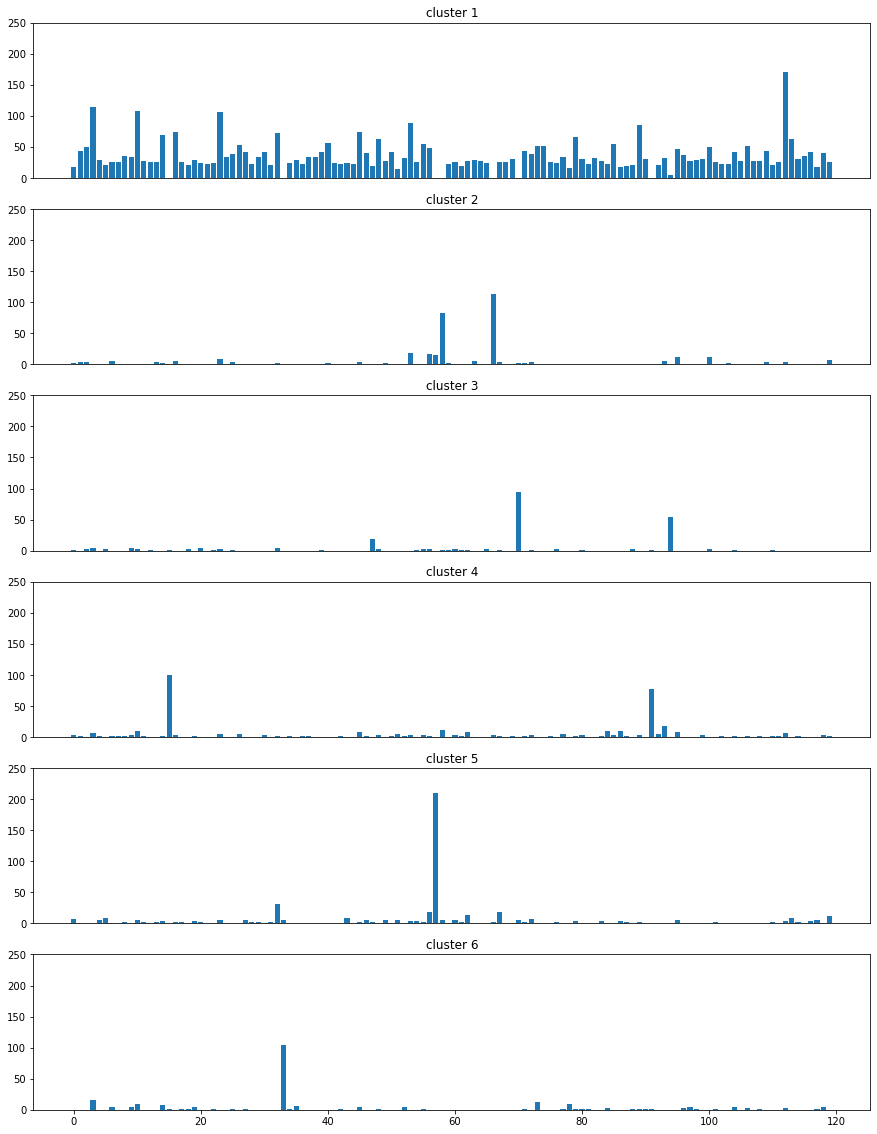

In [196]:
# Clustering visualization. Set vert = True for vertical barchart, False for horizontal barchart

vert = True
indices = df_description.columns

if vert == False:
    fig, axes = plt.subplots(1, K)
    for i in range(K):
        df_cluster_i = df_description.loc[cluster_products[i]]
        total = df_cluster_i.sum(axis = 0)
        axes[i].barh(y = range(len(total)), width = total)
        axes[i].set_title('cluster ' + str(i + 1))
        axes[i].set_xlim(0, 200)
    
    fig.set_figwidth(15)
    fig.set_figheight(8)
    plt.show()

else:
    fig, axes = plt.subplots(K, 1)
    for i in range(K):
        df_cluster_i = df_description.loc[cluster_products[i]]
        total = df_cluster_i.sum(axis = 0)
        axes[i].bar(x = range(len(total)), height = total)
        axes[i].set_title('cluster ' + str(i + 1))
        axes[i].set_ylim(0, 250)
        if i < K - 1:
            axes[i].set_xticks([])
            
    fig.set_figwidth(15)
    fig.set_figheight(20)
    plt.show()

# Result: In any description, any specific word will only occur once (maximum twice). Since the peaks in the word 
#         count for each cluster are for different words, there is some useful clustering based on product description,
#          although it is not perfect. If product tags were available, this clustering would not be required. 

In [162]:
N = 50
top_n = []
feature_names = count_vec.get_feature_names()
counts = np.asarray(description_matrix.sum(axis = 0))[0]
top_n_idx = reversed(np.argsort(counts)[-N:])

for idx in top_n_idx:
    word = feature_names[idx]
    top_n.append(word)
    
print(f'top {N} (stem) words: \n{top_n}')

top 50 (stem) words: 
['heart', 'vintag', 'bag', 'box', 'christma', 'light', 'glass', 'decor', 'design', 'candl', 'metal', 'holder', 'retrospot', 'flower', 'hang', 'card', 'cake', 'rose', 'paper', 'silver', 'garden', 'wall', 'mug', 'green', 'star', 'egg', 'sign', 'polkadot', 'cover', 'assort', 'set', 'tin', 'mirror', 'necklac', 'ivori', 'mini', 'wrap', 'tree', 'love', 'art', 'tea', 'cream', 'wooden', 'frame', 'zinc', 'bowl', 'gift', 'cushion', 'easter', 'colour']


In [163]:
cluster_words_list = []
columns = df_description.columns

for i in range(K):
    df_cluster_i = df_description.loc[cluster_products[i]]
    total_i = df_cluster_i.sum(axis = 0)
    perc_i = total_i / counts
    thresholded = np.argwhere(perc_i > 0.75)
    
    for idx in thresholded:
        cluster_words_list.append({
            'Cluster': i + 1, 'Word': columns[idx][0], 
            'Perc': perc_i[idx][0], 'Total': total_i[idx][0]
        })


C:\Users\user\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


In [164]:
clustering_results = pd.DataFrame(cluster_words_list).sort_values('Total', ascending = False).reset_index(drop = True)
clustering_results 

# Results: Single clusters have been able to capture more than 75% occurrences of these 76 out of 120 words.  
#          The total occurrences of each word is also shown. The clustering has not just been able to categorize
#          words that occur only a few times (results are sorted by total occurrence count). 

,Cluster,Word,Perc,Total
0,5,heart,0.933333,210
1,1,vintag,0.909574,171
2,1,bag,0.814286,114
3,2,light,0.949580,113
4,1,box,0.800000,108
...,...,...,...,...
93,1,cat,0.833333,20
94,1,tube,0.833333,20
95,1,rabbit,0.769231,20
96,1,purs,0.791667,19


In [165]:
clustering_results['Word'].isin(top_n).sum() 

# Result: The number of words in top 50 (N) that have been cleanly (>75%) assigned to a cluster. So, 
#         the most popular words have been cleanly clustered into specific categories. Thus products 
#         with these word occurrences will be clustered well based on the product description.  

41

In [166]:
df_list_dicts = []
index_names = []
for (user, group) in df_gpby:
    user_dict = dict()
    index_names.append(user)
    for k in range(K):
        products = cluster_products[k]
        group_cluster_k = group.loc[group['ItemCode'].isin(products)]
        group_cluster_k['total'] = group_cluster_k['CostPerItem'] * group_cluster_k['NumberOfItemsPurchased']
        user_dict['categ' + str(k + 1)] = group_cluster_k['total'].sum()
    df_list_dicts.append(user_dict)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [167]:
df_categ_spent = pd.DataFrame(df_list_dicts, index = index_names)
users = users.join(df_categ_spent)
users.head()

,n_transactions,transaction_hour,Mean,Min,Max,Sum,Africa,Asia,Europe,North America,Australia,South America,days_since,categ1,categ2,categ3,categ4,categ5,categ6
UserId,,,,,,,,,,,,,,,,,,,
272517,9,12.000000,18.060000,1.62,82.80,162.54,0,0,1,0,0,0,441.0,152.82,0.00,0.00,0.00,0.00,9.72
315546,60,9.100000,32.085000,5.19,316.71,1925.10,0,0,1,0,0,0,525.0,1309.26,73.44,134.04,97.08,278.88,32.40
329889,6,6.000000,92.395000,67.77,158.76,554.37,0,0,1,0,0,0,568.0,327.21,158.76,0.00,0.00,0.00,68.40
344232,43,8.000000,21.035581,2.28,92.04,904.53,0,0,1,0,0,0,554.0,644.16,92.04,0.00,104.31,34.80,29.22
358575,77,8.246753,44.914286,1.74,246.33,3458.40,0,0,1,0,0,0,275.0,2575.02,401.04,14.16,242.61,210.00,15.57


In [168]:
users.columns

Index(['n_transactions', 'transaction_hour', 'Mean', 'Min', 'Max', 'Sum',
       'Africa', 'Asia', 'Europe', 'North America', 'Australia',
       'South America', 'days_since', 'categ1', 'categ2', 'categ3', 'categ4',
       'categ5', 'categ6'],
      dtype='object')

### Features simplified

In [169]:
prd_categs = ['categ1', 'categ2', 'categ3', 'categ4', 'categ5', 'categ6']
prd_cutoff = users[prd_categs].quantile(0.75).to_dict()
prd_cutoff

{'categ1': 5000.820000000001,
 'categ2': 383.94000000000005,
 'categ3': 124.5,
 'categ4': 204.09000000000003,
 'categ5': 408.24,
 'categ6': 307.8}

In [170]:
def major_buyer(i):
    def major_buyer_i(series):
        if series['categ' + str(i)] >= prd_cutoff['categ' + str(i)]:
            return 1
        else:
            return 0
        
    return major_buyer_i
    

In [171]:
for i in range(1, 7):
    major_buyer_i = major_buyer(i) 
    users['cat' + str(i)] = users.apply(major_buyer_i, axis = 1)


In [172]:
users

,n_transactions,transaction_hour,Mean,Min,Max,Sum,Africa,Asia,Europe,North America,...,categ3,categ4,categ5,categ6,cat1,cat2,cat3,cat4,cat5,cat6
UserId,,,,,,,,,,,,,,,,,,,,,
272517,9,12.000000,18.060000,1.62,82.80,162.54,0,0,1,0,...,0.00,0.00,0.00,9.72,0,0,0,0,0,0
315546,60,9.100000,32.085000,5.19,316.71,1925.10,0,0,1,0,...,134.04,97.08,278.88,32.40,0,0,1,0,0,0
329889,6,6.000000,92.395000,67.77,158.76,554.37,0,0,1,0,...,0.00,0.00,0.00,68.40,0,0,0,0,0,0
344232,43,8.000000,21.035581,2.28,92.04,904.53,0,0,1,0,...,0.00,104.31,34.80,29.22,0,0,0,0,0,0
358575,77,8.246753,44.914286,1.74,246.33,3458.40,0,0,1,0,...,14.16,242.61,210.00,15.57,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310632,2,5.000000,12.855000,8.10,17.61,25.71,0,0,1,0,...,0.00,0.00,0.00,8.10,0,0,0,0,0,0
370251,39,7.974359,56.221538,12.06,82.08,2192.64,0,0,1,0,...,31.08,91.80,284.34,188.64,0,0,0,0,0,0
327264,122,8.360656,24.510246,3.54,186.84,2990.25,0,0,1,0,...,15.54,400.29,240.90,26.34,0,0,0,1,0,0


### Clusterin using RFM (Recency, Frequency, Monetary) features

In [173]:
u_rfm = users[['n_transactions', 'Sum', 'days_since']]
u_rfm

,n_transactions,Sum,days_since
UserId,,,
272517,9,162.54,441.0
315546,60,1925.10,525.0
329889,6,554.37,568.0
344232,43,904.53,554.0
358575,77,3458.40,275.0
...,...,...,...
310632,2,25.71,348.0
370251,39,2192.64,286.0
327264,122,2990.25,245.0


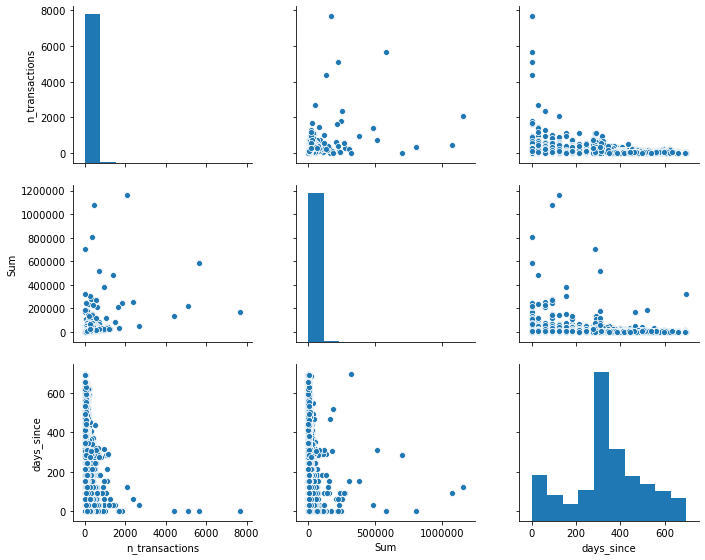

In [174]:
pplot = sns.pairplot(u_rfm);
pplot.fig.set_size_inches(10,8)


In [175]:
scaler = MinMaxScaler() 
users_scaled = scaler.fit_transform(u_rfm)

In [176]:
for n_clusters in range(2, 10):
    
    kmeans = KMeans(init = 'k-means++', n_clusters = n_clusters, n_init = 20, random_state = 7)
    clusters = kmeans.fit_predict(users_scaled)
    silhouette_avg = silhouette_score(users_scaled, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", round(silhouette_avg, 4))


For n_clusters = 2 The average silhouette_score is : 0.5777
For n_clusters = 3 The average silhouette_score is : 0.6384
For n_clusters = 4 The average silhouette_score is : 0.5831
For n_clusters = 5 The average silhouette_score is : 0.5825
For n_clusters = 6 The average silhouette_score is : 0.5238
For n_clusters = 7 The average silhouette_score is : 0.5311
For n_clusters = 8 The average silhouette_score is : 0.5264
For n_clusters = 9 The average silhouette_score is : 0.5376


In [177]:
kmeans = KMeans(init = 'k-means++', n_clusters = 3, n_init = 20, random_state = 7)
kmeans.fit(users_scaled)
clusters = kmeans.predict(users_scaled)

Counter(clusters)

Counter({1: 1127, 0: 2401, 2: 805})

In [178]:
def silhouette_analysis(X, cluster_labels):
    
    y_lower = 10
    n_clusters = len(np.unique(cluster_labels))
    silhouette_values = silhouette_samples(X, cluster_labels)
    
    for i in range(n_clusters):
    
        ith_cluster_silhouette_values = silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor = color, edgecolor = color, alpha = 0.7)

        plt.text(-0.025, y_lower + 0.5 * size_cluster_i, str(i + 1))
        y_lower = y_upper + 10
    
    plt.title('Silhouette plot')
    plt.plot()

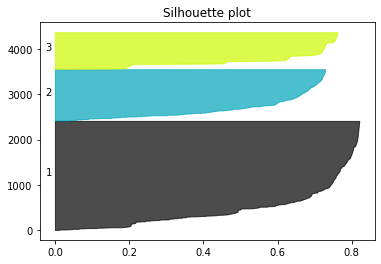

In [179]:
silhouette_analysis(users_scaled, clusters)

In [180]:
u_rfm['cluster'] = clusters
u_rfm

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,n_transactions,Sum,days_since,cluster
UserId,,,,
272517,9,162.54,441.0,1
315546,60,1925.10,525.0,1
329889,6,554.37,568.0,1
344232,43,904.53,554.0,1
358575,77,3458.40,275.0,0
...,...,...,...,...
310632,2,25.71,348.0,0
370251,39,2192.64,286.0,0
327264,122,2990.25,245.0,0


In [181]:
def percentile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'perc_{:2.0f}'.format(n*100)
    return percentile_

In [182]:
u_rfm.groupby(['cluster']).agg([percentile(0.25), percentile(0.50), percentile(0.75)])

# Observation: there is good separation of clusters with respect to Sum and days_since variable

n_transactions                       Sum                      \
               perc_25 perc_50 perc_75   perc_25  perc_50    perc_75   
cluster                                                                
0                   21      46     100  1480.020  3181.56   7000.230   
1                    9      19      35   717.375  1313.82   2395.365   
2                   44     108     219  2822.760  7003.26  15919.950   

        days_since                  
           perc_25 perc_50 perc_75  
cluster                             
0            303.0   321.0   358.0  
1            483.0   537.0   601.0  
2             30.0    61.0   123.0

In [183]:
u_rfm.drop('cluster', axis = 1, inplace = True)

C:\Users\user\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### (More) Feature selection

#### Add product categories (simplified)

In [184]:
prod = users[['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6']]
users_prd = pd.concat([u_rfm, prod], axis = 1)
users_scaled = scaler.fit_transform(users_prd)

In [185]:
users_prd

,n_transactions,Sum,days_since,cat1,cat2,cat3,cat4,cat5,cat6
UserId,,,,,,,,,
272517,9,162.54,441.0,0,0,0,0,0,0
315546,60,1925.10,525.0,0,0,1,0,0,0
329889,6,554.37,568.0,0,0,0,0,0,0
344232,43,904.53,554.0,0,0,0,0,0,0
358575,77,3458.40,275.0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
310632,2,25.71,348.0,0,0,0,0,0,0
370251,39,2192.64,286.0,0,0,0,0,0,0
327264,122,2990.25,245.0,0,0,0,1,0,0


In [186]:
for n_clusters in range(3, 15):
    
    kmeans = KMeans(init = 'k-means++', n_clusters = n_clusters, n_init = 20, random_state = 7)
    clusters = kmeans.fit_predict(users_scaled)
    silhouette_avg = silhouette_score(users_scaled, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

# Observation: The avg. silhouette values are smaller than without product inclination features

For n_clusters = 3 The average silhouette_score is : 0.37747215526150835
For n_clusters = 4 The average silhouette_score is : 0.4001563590591696
For n_clusters = 5 The average silhouette_score is : 0.4130459341378793
For n_clusters = 6 The average silhouette_score is : 0.4442480375583149
For n_clusters = 7 The average silhouette_score is : 0.4541184876201142
For n_clusters = 8 The average silhouette_score is : 0.4543026301263454
For n_clusters = 9 The average silhouette_score is : 0.47763034824485495
For n_clusters = 10 The average silhouette_score is : 0.4866466490604516
For n_clusters = 11 The average silhouette_score is : 0.499743035498929
For n_clusters = 12 The average silhouette_score is : 0.5127595689394536
For n_clusters = 13 The average silhouette_score is : 0.418788915052501
For n_clusters = 14 The average silhouette_score is : 0.42907774905876594


#### Add location (continent)

In [187]:
cont = users[['Africa', 'Asia', 'Europe', 'North America', 'Australia', 'South America']]
users_cont = pd.concat([u_rfm, cont], axis = 1)
users_scaled = scaler.fit_transform(users_cont)

In [188]:
for n_clusters in range(2, 10):
    
    kmeans = KMeans(init = 'k-means++', n_clusters = n_clusters, n_init = 20, random_state = 7)
    clusters = kmeans.fit_predict(users_scaled)
    silhouette_avg = silhouette_score(users_scaled, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

# Observation: the avg. silhouette values are larger than without location features
# Conclusion : continent features adds useful information for clustering

For n_clusters = 2 The average silhouette_score is : 0.54089668269044
For n_clusters = 3 The average silhouette_score is : 0.598828435932839
For n_clusters = 4 The average silhouette_score is : 0.6344868618389998
For n_clusters = 5 The average silhouette_score is : 0.6382745318792523
For n_clusters = 6 The average silhouette_score is : 0.5837122628222308
For n_clusters = 7 The average silhouette_score is : 0.5859592104220599
For n_clusters = 8 The average silhouette_score is : 0.5858250038912597
For n_clusters = 9 The average silhouette_score is : 0.5282146549956431


In [189]:
kmeans = KMeans(init = 'k-means++', n_clusters = 4, n_init = 20, random_state = 7)
clusters = kmeans.fit_predict(users_scaled)

Counter(clusters)

Counter({1: 1108, 0: 2370, 3: 803, 2: 52})

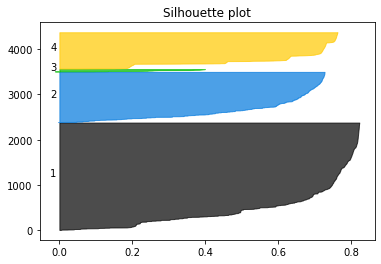

In [190]:
silhouette_analysis(users_scaled, clusters)

In [191]:
users_cont['cluster'] = clusters

In [192]:
users_cont.groupby(['cluster']).agg(
    n_trans_25 = ('n_transactions', percentile(0.25)), 
    n_trans_50 = ('n_transactions', percentile(0.50)), 
    n_trans_75 = ('n_transactions', percentile(0.75)), 
    sum_25 = ('Sum', percentile(0.25)), 
    sum_50 = ('Sum', percentile(0.50)), 
    sum_75 = ('Sum', percentile(0.75)), 
    days_since_25 = ('days_since', percentile(0.25)), 
    days_since_50 = ('days_since', percentile(0.50)), 
    days_since_75 = ('days_since', percentile(0.75)),
)

# Observation: there is good separation with respect to variabls Sum and days_since, but not so with n_transactions

,n_trans_25,n_trans_50,n_trans_75,sum_25,sum_50,sum_75,days_since_25,days_since_50,days_since_75
cluster,,,,,,,,,
0,21,46,99.75,1475.1450,3142.065,6874.845,303.0,320.0,357.0
1,9,19,35.00,717.8175,1307.610,2370.900,482.0,537.0,602.0
2,12,33,88.50,1649.8350,5165.100,9825.990,341.0,416.0,543.0
3,44,108,219.00,2831.5200,7003.260,15863.505,30.0,61.0,123.0


In [194]:
users_cont.groupby(['cluster']).agg(
    Asia_ = ('Asia', 'mean'), 
    Africa_ = ('Africa', 'mean'), 
    Europe_ = ('Europe', 'mean'), 
    North_America_ = ('North America', 'mean'), 
    South_America_ = ('South America', 'mean'), 
)

# Observation: All European users are clustered into clusters 0, 1 and 3, and all non
#              European users are clustered into cluster 2. 

,Asia_,Africa_,Europe_,North_America_,South_America_
cluster,,,,,
0,0.000000,0.000000,1,0.000000,0.000000
1,0.000000,0.000000,1,0.000000,0.000000
2,0.461538,0.019231,0,0.326923,0.019231
3,0.000000,0.000000,1,0.000000,0.000000


### Result
* Best result was obtained using features: days_since, n_transactions, Sum and continent features.
* The optimal number of clusters corresponding to best silhoette score is 4 using KMeans clustering. 